# Data Parameters

In [1]:
# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [2]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("../..")

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

import numpy as np
# Temporal train-test split function
def temporal_train_test_split(X, Y, train_size=0.8):
    """Split data temporally - first portion for training, last portion for testing"""
    split_idx = int(X.shape[0] * train_size)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    Y_train = Y[:split_idx]
    Y_test = Y[split_idx:]
    
    print(f"Temporal split at index {split_idx}:")
    print(f"  Training: samples 0-{split_idx-1} ({train_size*100:.0f}% of time)")
    print(f"  Testing: samples {split_idx}-{len(X)-1} ({(1-train_size)*100:.0f}% of time)")
    
    return X_train, X_test, Y_train, Y_test
    
def temporal_train_test_valid_split(X, Y, train_size=0.7, test_size=0.2, valid_size=0.1):
    train_split = int(X.shape[0] * train_size)
    test_split = int(X.shape[0] * (train_size + valid_size))
    
    X_train = X[:train_split]
    X_valid = X[train_split:test_split]
    X_test = X[test_split:]
    Y_train = Y[:train_split]
    Y_valid = Y[train_split:test_split]
    Y_test = Y[test_split:]
    
    print(f"Temporal split at indices {train_split} and {test_split}:")
    print(f"  Training: samples 0-{train_split-1} ({train_size*100:.0f}% of time)")
    print(f"  Validation: samples {train_split}-{test_split-1} ({valid_size*100:.0f}% of time)")
    print(f"  Testing: samples {test_split}-{len(X)-1} ({test_size*100:.0f}% of time)")
    
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

import joblib
def std_scale_train_test_valid(X_train, X_test, X_valid, save=False, save_path='data'):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
    scaled_valid = scaler.transform(X_valid.reshape(-1, 1)).reshape(X_valid.shape)

    if save:
        joblib.dump(scaler, save_path, compress=True)

    return scaled_train, scaled_test, scaled_valid

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

In [4]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# ========== 2. Load AirNow Data ==========
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    save_dir='data/two_years_with_hrrr/airnow_cache/airnow.json',
    processed_cache_dir='data/two_years_with_hrrr/airnow_cache/airnow_processed.npz',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    use_mask=False,
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
    print(f"  Sensor names: {airnow_data.sensor_names}")
else:
    print("  No target stations available")

Elevation data not found at ../libs/inputs/elevation.npy. Using flat elevation.
Mask usage disabled. All sensors within extent will be included.
Loading processed AirNow data from cache: data/two_years_with_hrrr/airnow_cache/airnow_processed.npz
✓ Successfully loaded processed data from cache
  - Data shape: (17540, 5, 40, 40, 1)
  - Found 8 sensor locations
✓ AirNow data shape: (17540, 5, 40, 40, 1)
  Target stations shape: (17535, 5, 8)
  Number of sensors: 8
  Sensor names: ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']


In [5]:
print("Data shape before trimming:")
print(f"  AirNow: {X_airnow.shape}")
print(f"  Targets: {Y_targets.shape}")

# Find the minimum number of timesteps across all datasets
min_timesteps = min(X_airnow.shape[0], Y_targets.shape[0])
print(f"Minimum timesteps across all datasets: {min_timesteps}")

# Trim all datasets to the same number of timesteps
X_airnow = X_airnow[:min_timesteps]
Y_targets = Y_targets[:min_timesteps]  # Don't forget to trim Y_targets too!

print(f"Data shapes after trimming:")
print(f"  AirNow: {X_airnow.shape}")
print(f"  Y_targets: {Y_targets.shape}")

# Display the number of channels from each source
airnow_channels = X_airnow.shape[4]

# Create combined channel names
all_channel_names = ["AirNow_PM25"]
print(f"Channel names: {all_channel_names}")

Data shape before trimming:
  AirNow: (17540, 5, 40, 40, 1)
  Targets: (17535, 5, 8)
Minimum timesteps across all datasets: 17535
Data shapes after trimming:
  AirNow: (17535, 5, 40, 40, 1)
  Y_targets: (17535, 5, 8)
Channel names: ['AirNow_PM25']


# AirNow Investigation

In [6]:
# one frame, one station
# since x is [0, 1, 2, 3, 4] and y is [5, 6, 7, 8, 9], t-1 -> t should be the last x frame and first y frame
# LA is station 4
one_frame_X = X_airnow[:, [-1], :, :, :].copy()
one_frame_Y = Y_targets[:, 0, [4]].copy()

# print data
print(f'X shape: {one_frame_X.shape}, Y shape: {one_frame_Y.shape}')
'''
print('\nSecond sample:')
for i in range(one_frame_X.shape[2]):
    print(one_frame_X[1, :, i].reshape(-1))
'''
print(f"Target for first sample (should match second X sample): {one_frame_Y[0]}")

# validate t-1 != t (X current, Y current)
print('\nTesting that next frame of X matches previous frame in Y')
print('For same frame:')
match = np.where(np.isclose(one_frame_X[0], one_frame_Y[0]))
print(
    "Success: no matches found" 
    if match[0].size == 0 
    else f"Error: matches found on indexes {list(zip(*match))}"
)

# validate t == t (X future, Y current)
print('\nFor Y current, X one index ahead:')
match = np.where(np.isclose(one_frame_X[0], one_frame_Y[0]))
print(
    "Error: no matches found" 
    if match[0].size == 0 
    else f"Success: matches found on indexes {list(zip(*match))}"
)

# validate t == t (X future, Y current)
print('\nFor Y current, ANY X frame with the LA station:')
match = np.where(np.isclose(one_frame_X[:, 0, 11, 17], one_frame_Y))
print(
    "Error: no matches found" 
    if match[0].size == 0 
    else f"Success: matches found on indexes {list(zip(*match))}"
)

X shape: (17535, 1, 40, 40, 1), Y shape: (17535, 1)
Target for first sample (should match second X sample): [6.6]

Testing that next frame of X matches previous frame in Y
For same frame:
Success: no matches found

For Y current, X one index ahead:
Error: no matches found

For Y current, ANY X frame with the LA station:
Success: matches found on indexes [(16568, 0)]



Examining PM2.5 values at ground sensor locations:


,Sensor,Coords,Grid Value,Target
0,Simi Valley - Cochran Street,"(1, 8)",7.596433,4.1
1,Reseda,"(4, 12)",7.052654,12.0
2,Santa Clarita,"(5, 4)",7.828238,9.4
3,North Holywood,"(8, 12)",6.485969,5.1
4,Los Angeles - N. Main Street,"(11, 17)",5.154740,6.6
5,Compton,"(12, 23)",4.708209,7.6
6,Long Beach Signal Hill,"(13, 28)",5.076130,4.2
7,Glendora - Laurel,"(20, 14)",6.533259,3.8


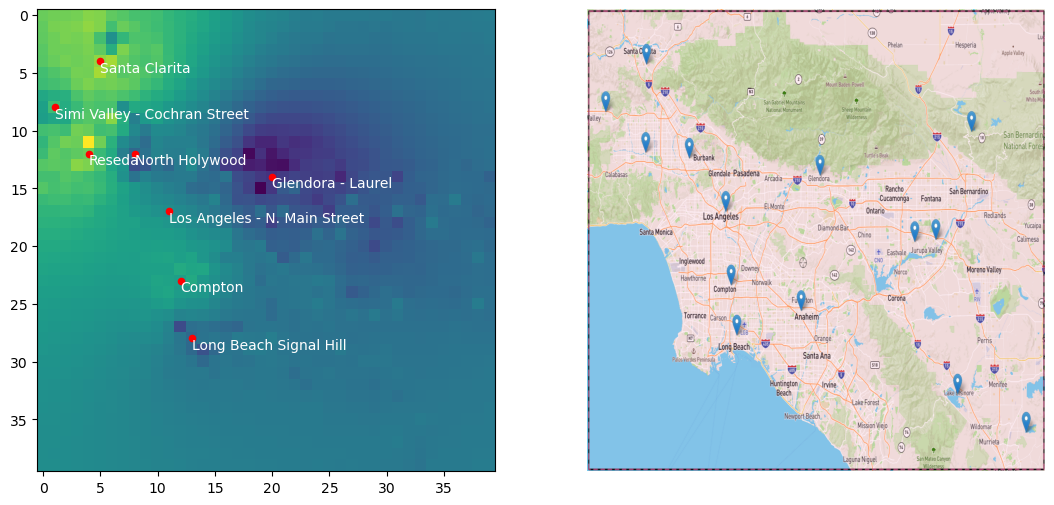

In [7]:
import pandas as pd

print("\nExamining PM2.5 values at ground sensor locations:")
sensor_info = []
for i, d in enumerate(airnow_data.air_sens_loc.items()):
    site, yx = d
    y, x = yx
    sensor_info.append([
        site, 
        (x, y), 
        one_frame_X[0, 0, x, y][0], 
        Y_targets[0, 0, i]
    ])

df = pd.DataFrame(sensor_info, columns=["Sensor", "Coords", "Grid Value", "Target"])
display(df)

import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('/home/mgraca/Pictures/Screenshots/approx_sites.png')

fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# subplot 1
axes[0].imshow(one_frame_X[0, 0], aspect='auto')
for site, yx in airnow_data.air_sens_loc.items():
    y, x = yx
    axes[0].text(x, y, site, color='white', fontsize=10, ha='left', va='top')
    axes[0].scatter(x, y, color='red', s=20)

# subplot 2
axes[1].imshow(img, aspect='auto')
axes[1].axis('off')

plt.show()

In [8]:
# theory: gaussian smoothing messes up the real data
print(
    f"Average PM2.5 error between observed and interpolated pixel for LA sensor: " 
    f"{np.sum(np.abs(one_frame_X[:, 0, 17, 11][0] - one_frame_Y)) / (len(one_frame_Y)):.2f}"
)

running_sum = 0
denom = 0
for i, d in enumerate(airnow_data.air_sens_loc.items()):
    site, xy = d
    y, x = yx
    error = np.sum(np.abs(one_frame_X[:, 0, x, y][0] - Y_targets[:, 0, i])) / (len(Y_targets))
    running_sum += error
    denom += 1
    print(f"{site} sensor's average PM2.5 error: {error:.2f}")

print(f"\nAverage PM2.5 error between observed and interpolated pixel: {running_sum / denom:.2f}")

Average PM2.5 error between observed and interpolated pixel for LA sensor: 6.51
Simi Valley - Cochran Street sensor's average PM2.5 error: 3.53
Reseda sensor's average PM2.5 error: 5.28
Santa Clarita sensor's average PM2.5 error: 4.29
North Holywood sensor's average PM2.5 error: 5.41
Los Angeles - N. Main Street sensor's average PM2.5 error: 6.41
Compton sensor's average PM2.5 error: 6.48
Long Beach Signal Hill sensor's average PM2.5 error: 4.58
Glendora - Laurel sensor's average PM2.5 error: 5.43

Average PM2.5 error between observed and interpolated pixel: 5.18


In [9]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = temporal_train_test_valid_split(
    one_frame_X, one_frame_Y, train_size=0.7, test_size=0.15, valid_size=0.15
)
X_scaled_train, X_scaled_test, X_scaled_valid = std_scale_train_test_valid(
    X_train, X_test, X_valid, save=False
)

Temporal split at indices 12274 and 14904:
  Training: samples 0-12273 (70% of time)
  Validation: samples 12274-14903 (15% of time)
  Testing: samples 14904-17534 (15% of time)


# Model Definition

In [10]:
output_size = 1
input_shape = X_scaled_train.shape[1:] # (frames, height, width, channels)

print(
    f"X_train_scaled shape:  {X_scaled_train.shape}\n"
    f"Y_train shape:         {Y_train.shape}\n\n"
    
    f"X_test_scaled shape:  {X_scaled_test.shape}\n"
    f"Y_test shape:         {Y_test.shape}\n\n"

    f"X_valid_scaled shape: {X_scaled_valid.shape}\n"
    f"Y_valid shape:        {Y_valid.shape}\n\n"

    f"Input shape:          {input_shape}\n"
    f"Output shape:         ({output_size})\n"
)

X_train_scaled shape:  (12274, 1, 40, 40, 1)
Y_train shape:         (12274, 1)

X_test_scaled shape:  (2631, 1, 40, 40, 1)
Y_test shape:         (2631, 1)

X_valid_scaled shape: (2630, 1, 40, 40, 1)
Y_valid shape:        (2630, 1)

Input shape:          (1, 40, 40, 1)
Output shape:         (1)



In [11]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
        filters=15, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True,
        #dropout=0.1,
        #recurrent_dropout=0.1,
        #kernel_regularizer=keras.regularizers.l2(0.01)
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

# applies layer to every temporal slice (first dimension)
# so for (5, 40, 40, 1), the layer is applied to each frame, a total of 5 times
#seq.add(TimeDistributed(Flatten()))
seq.add(Flatten())

#seq.add(Dropout(rate=0.1))

seq.add(Dense(output_size, activation='relu'))

seq.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001, weight_decay=0.01)
)
seq.summary()

2025-07-02 20:05:55.467608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-02 20:05:55.475858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751511955.486721   95950 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751511955.490219   95950 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-02 20:05:55.501165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 40, 40, 15)  │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 1, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 1, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,592 (279.66 KB)

 Trainable params: 71,592 (279.66 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.callbacks import EarlyStopping, TensorBoard
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)

# define list of callbacks we're gonna use
callbacks = [
    EarlyStopping(monitor='val_loss', patience=40),
    #TensorBoard(run_logdir, histogram_freq=1),
    #GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))
]

In [13]:
history = seq.fit(
    X_scaled_train,
    Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_scaled_valid, Y_valid),
    callbacks=callbacks
)

Epoch 1/200


I0000 00:00:1751511959.588956   96044 service.cc:148] XLA service 0x7fdb0800b650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751511959.588972   96044 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-07-02 20:05:59.654687: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751511959.949139   96044 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-07-02 20:06:00.218166: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_

 11/384 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9.5374

I0000 00:00:1751511961.924657   96044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.3517

2025-07-02 20:06:08.284564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,1,40,40]{3,2,1,0}, f32[15,1,3,3]{3,2,1,0}, f32[15]{0}, f32[18,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-02 20:06:08.332499: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[18,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[18,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.3388

2025-07-02 20:06:11.007966: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[6,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[6,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[6,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


384/384 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 8.3324 - val_loss: 2.8527
Epoch 2/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.9396 - val_loss: 2.7532
Epoch 3/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.9255 - val_loss: 2.8471
Epoch 4/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8971 - val_loss: 2.8332
Epoch 5/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8568 - val_loss: 2.6785
Epoch 6/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8400 - val_loss: 2.6862
Epoch 7/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.9383 - val_loss: 2.6667
Epoch 8/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8360 - val_loss: 2.6536
Epoch 9/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8592 - val_loss: 2.7672
Epoch 10/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8768 - val_loss: 2.6238
Epoch 11/200
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 2.8235 - val_loss: 2.6916
Epoch 12/200
384/384 ━━━━━━━━━━━━━━━━━━━━

# Model Evaluation


Evaluating model


2025-07-02 20:27:24.709461: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


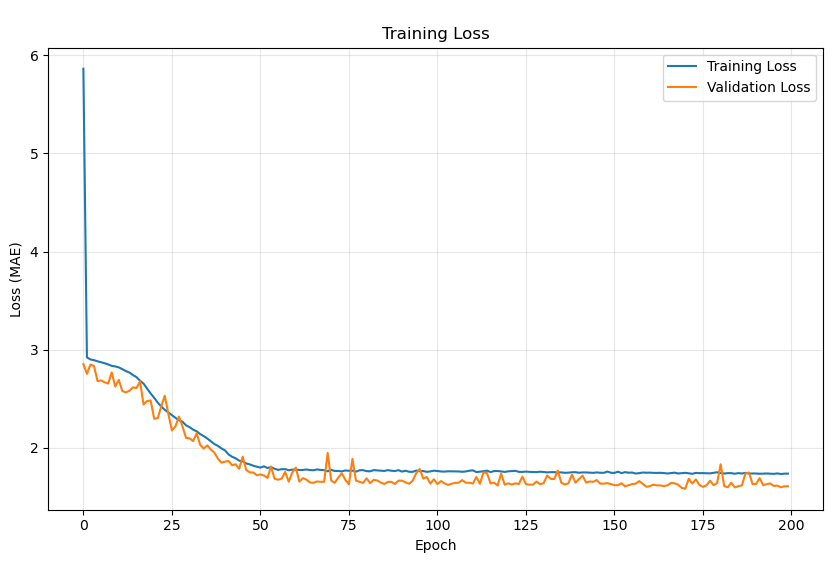

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
y_pred = seq.predict(X_scaled_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
import sys
sys.path.append('../..')
from libs.plotting import *

print(y_pred.shape, Y_test.shape)
print(f"RMSE: {rmse(y_pred, Y_test):.2f}")
print(f"NRMSE: {nrmse(y_pred, Y_test):.2f}")
print(f"MAE: {mae(y_pred, Y_test):.2f}")
print(f"R2: {r2_score(Y_test, y_pred):.2f}")

(2631, 1) (2631, 1)
RMSE: 2.37
NRMSE: 17.04
MAE: 1.54
R2: 0.86


In [16]:
comprehensive_frame_analysis(y_pred, Y_test, airnow_data.sensor_names)

Comprehensive frame analysis requires multi-frame predictions


# Plots

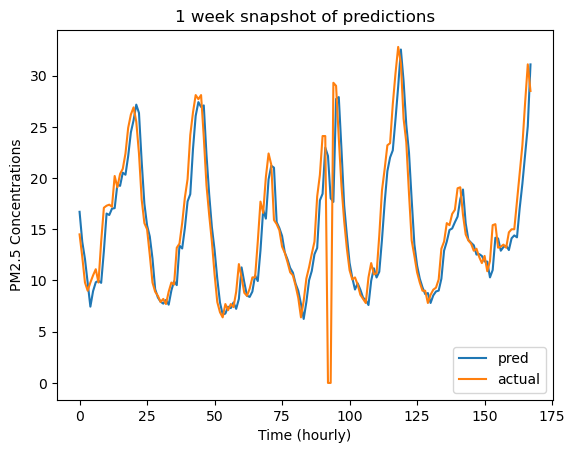

In [17]:
plt.plot(y_pred[1000:1168], label='pred')
plt.plot(Y_test[1000:1168], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")

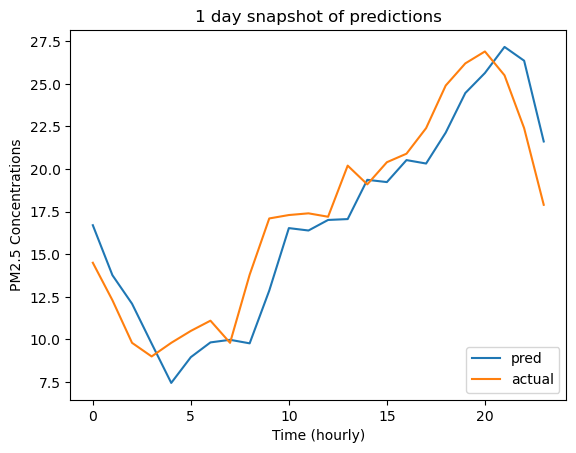

In [18]:
plt.plot(y_pred[1000:1024], label='pred')
plt.plot(Y_test[1000:1024], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 day snapshot of predictions")
plt.legend(loc="lower right")

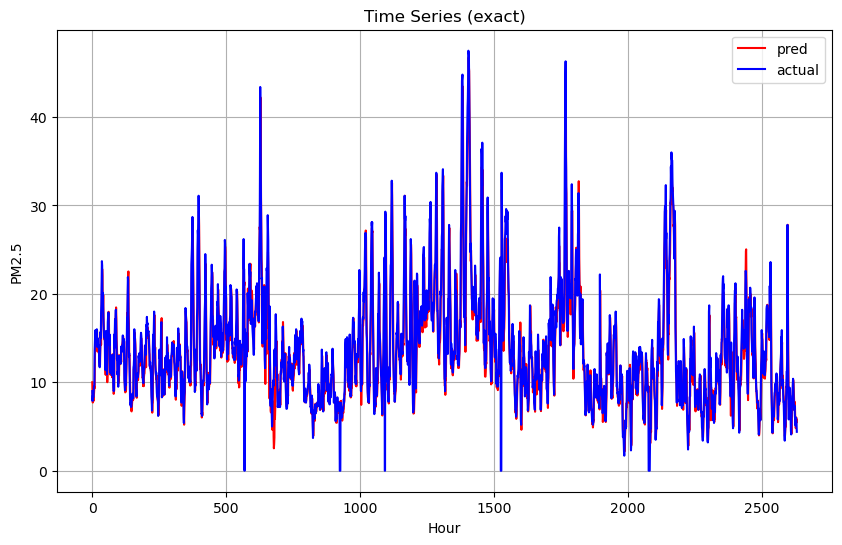

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(y_pred, label=f'pred', color='red')
plt.plot(Y_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

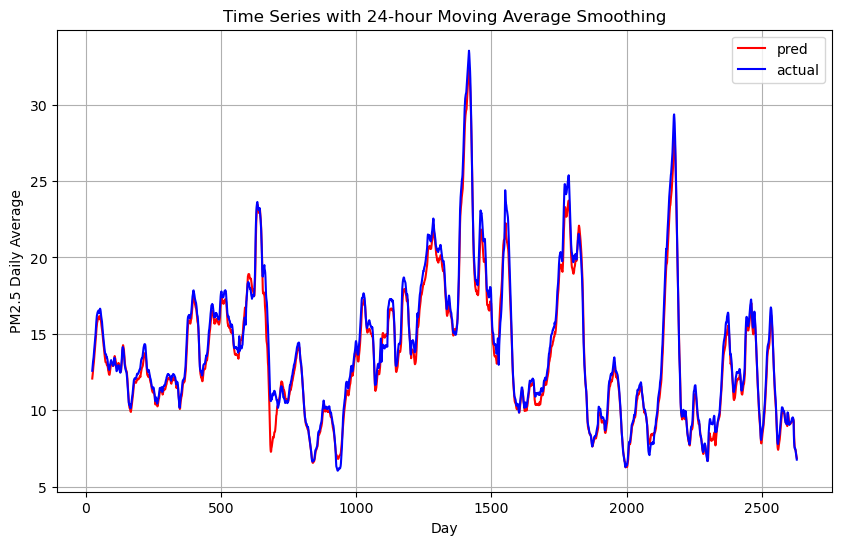

In [20]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

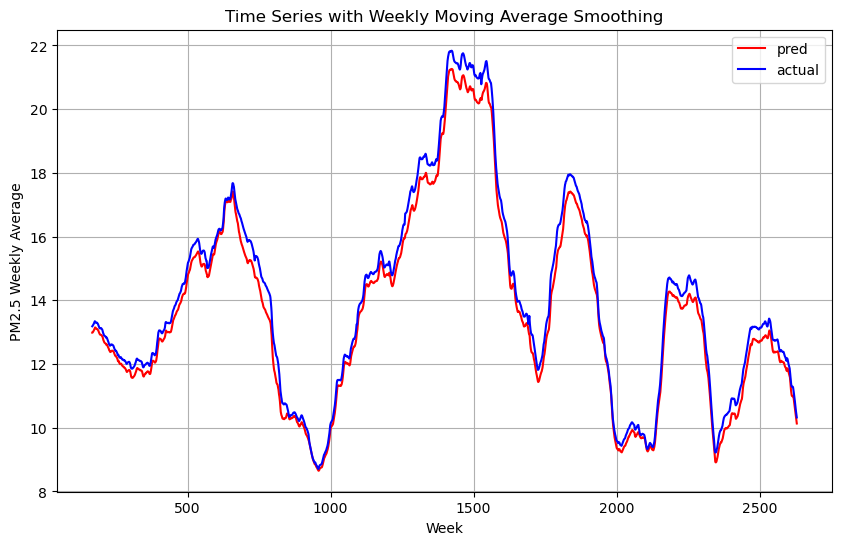

In [21]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

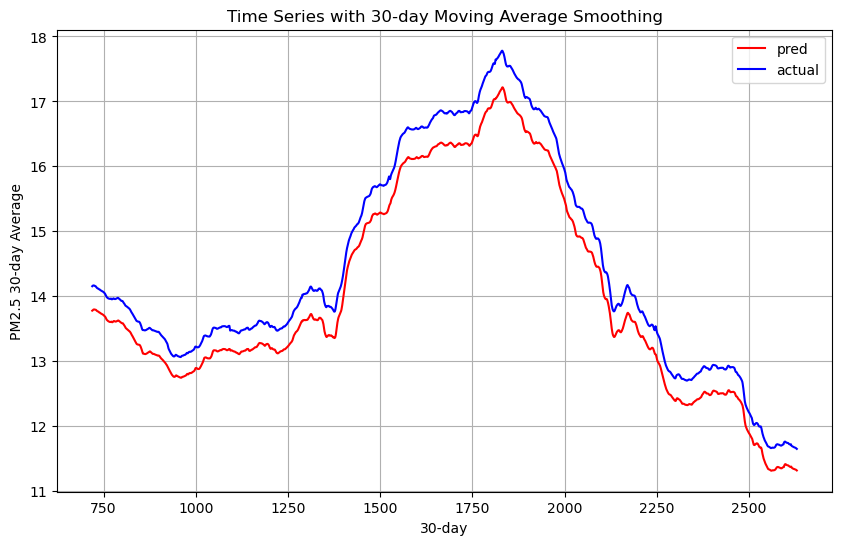

In [22]:
series_pred = pd.Series(np.squeeze(y_pred))
series_test = pd.Series(np.squeeze(Y_test))

window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()